jupyter nbconvert --to slides --post serve PresNotebook

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from sklearn import neighbors
from sklearn.neighbors import kneighbors_graph
from imblearn.under_sampling import RandomUnderSampler
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, concatenate, Dropout, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import functools
file = '/Users/cameronsellers/code/cecyprice/skin_lesion_detection/dataset/HAM10000_metadata.csv'
meta_data = pd.read_csv(file, ',')
file = '/Users/cameronsellers/code/cecyprice/skin_lesion_detection/dataset/hmnist_8_8_RGB.csv'
skin_df = pd.read_csv(file, ',')
from IPython.display import Image
from IPython.display import HTML
import binascii

In [2]:
meta_data['dx'] = meta_data['dx'].replace(['nv'],'Melanocytic nevi')
meta_data['dx'] = meta_data['dx'].replace(['mel'],'Melanoma')
meta_data['dx'] = meta_data['dx'].replace(['bkl'],'Benign keratosis-like lesions')
meta_data['dx'] = meta_data['dx'].replace(['bcc'],'Basal cell carcinoma')
meta_data['dx'] = meta_data['dx'].replace(['akiec'],'Actinic keratoses')
meta_data['dx'] = meta_data['dx'].replace(['vasc'],'Vascular lesions')
meta_data['dx'] = meta_data['dx'].replace(['df'],'Dermatofibroma')

In [3]:
# # fill 67 missing age values with mean
# meta_data['age'].fillna((meta_data['age'].mean()), inplace = True)
# # drop duplicates as duplicates evenly distributed across lesion types 
# meta_data = meta_data.drop_duplicates(subset=['lesion_id'], keep = 'first')

In [4]:
def balance(data):
    return data
def augment(data):
    return data

def balance2(data, under_sample_size):
        ## isolate nv rows
        data_nv = data[data['dx'] == 'Melanocytic nevi']
        # define scaling parameters 
        sample_size = under_sample_size
        scaling = under_sample_size / data_nv.shape[0] 
        # stratified sampling 
        rus = RandomUnderSampler(sampling_strategy={'lower extremity' : int(1224*scaling),
                                                    'trunk' : int(1153*scaling), 
                                                    'back' : int(1058*scaling),
                                                    'abdomen' : int(719*scaling), 
                                                    'upper extremity' : int(504*scaling) ,
                                                    'foot' : int(209*scaling), 
                                                    'unknown' : int(175*scaling),
                                                    'chest' : int(112*scaling),
                                                    'face' : int(61*scaling),
                                                    'neck' : int(60*scaling), 
                                                    'genital' : int(43*scaling), 
                                                    'hand' : int(39*scaling), 
                                                    'scalp' : int(24*scaling), 
                                                    'ear' : int(19*scaling),
                                                    'acral' : int(3*scaling)+1
                                                   }, 
                                   random_state=None,
                                   replacement=False,
                                )
        ## fit strtaified sampling model 
        n_x, n_y = rus.fit_resample(data_nv, data_nv['localization'])
        ## delete nv rows from original dataset
        no_nv_data = data[data.dx != 'Melanocytic nevi']
        data = pd.concat([n_x, no_nv_data], axis=0)
        return data

In [5]:
def hide_code_in_slideshow():  
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

In [6]:
repetition_counts = meta_data.groupby('lesion_id').agg({'image_id': 'count', 'dx_type': 'count', 'age': 'mean', 'sex': 'count', 'localization': 'count', 'dx': 'first', }).reset_index()
repetition_counts.columns = ['lesion_id', 'image_count', 'count_dx_type', 'mean_age', 'count_sex', 'count_location', 'dx']

# Team 2 - SKIN LESION DETECTION
---

## Project Aims 
---

**1. To create a model capable of identifying different types of skin-lesions from images**


**2. To create an app that predicts lesion types using image and patient data**

# AGENDA
---

1. Data Overview
2. Data Visualisation
3. Data Preparation
4. Model Construction and Training
5. Evaluation 
6. Streamlit app
7. Limitations & Future perspectives

# DATA OVERVIEW
---

### Dataset Overview
---

The HAM10000 ("Human Against Machine with 10000 training images") dataset:

- 10,015 images of labelled skin lesions

- Patient meta-data

## Image Dataset

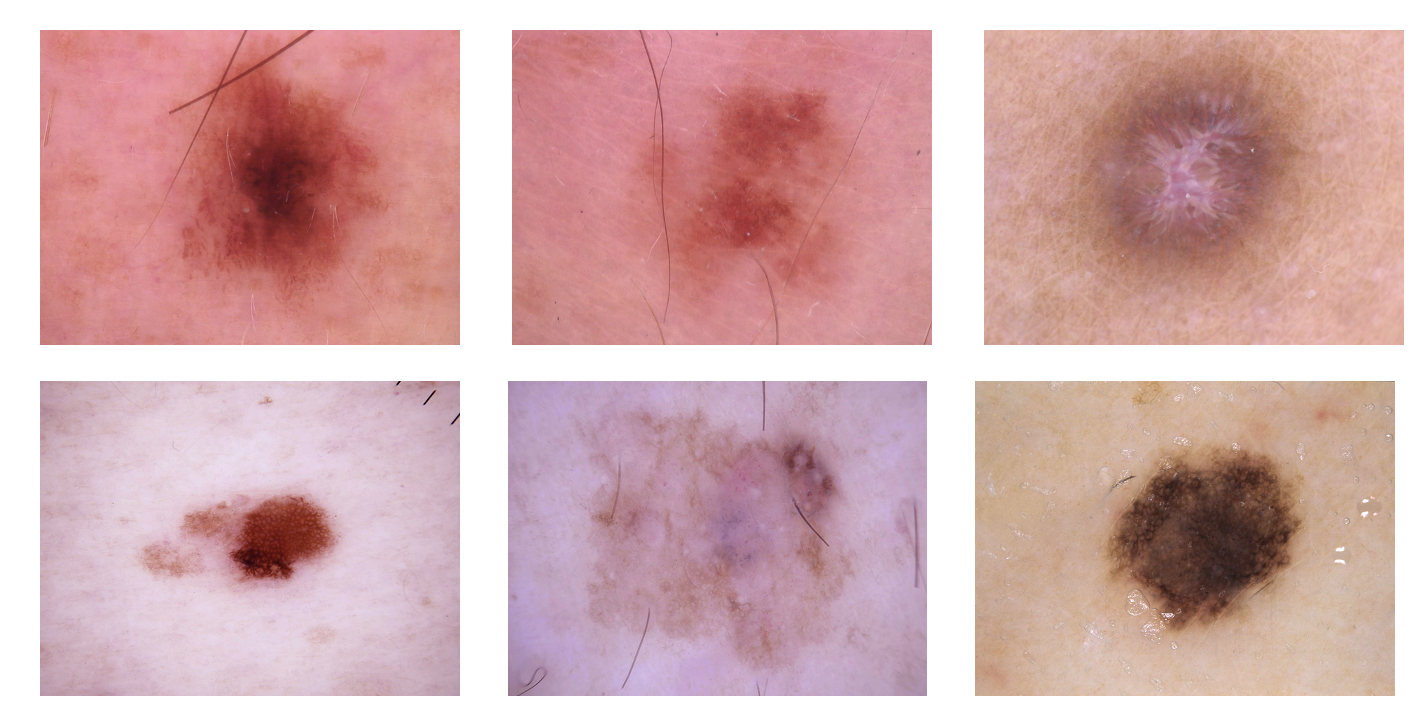

In [7]:
hide_code_in_slideshow()
Image("SKL.png")

## Metadata
---

Our metadata contains information for each patient:

- 'dx' - the type of skin lesion
- 'dx-type' - how the lesion was discovered
- Patient sex
- Patient age
- Lesion location

In [8]:
hide_code_in_slideshow()
meta_data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,Benign keratosis-like lesions,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Benign keratosis-like lesions,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Benign keratosis-like lesions,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Benign keratosis-like lesions,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Benign keratosis-like lesions,histo,75.0,male,ear


# DATA VISUALISATION
---

In [9]:
plt.style.use('seaborn-dark')

Text(0.5, 1.0, 'Localization of the skin lesion')

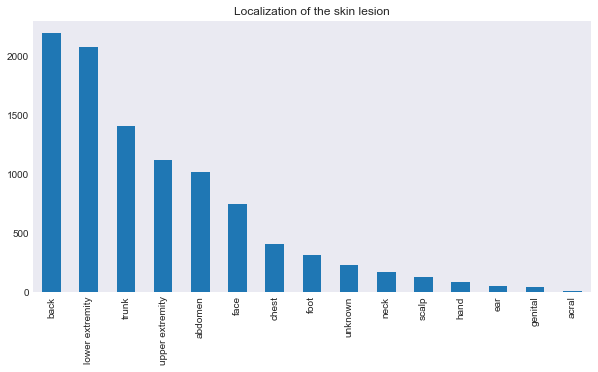

In [10]:
hide_code_in_slideshow()
plt.figure(figsize=(10, 5))
meta_data['localization'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Localization of the skin lesion')

Text(0.5, 1.0, 'Distribution of male and female patients')

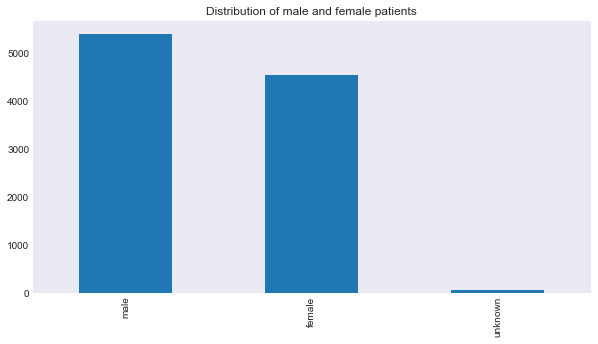

In [11]:
hide_code_in_slideshow()
plt.figure(figsize=(10, 5))
meta_data['sex'].value_counts().plot(kind='bar')
plt.title('Distribution of male and female patients')

Text(0.5, 1.0, 'Distribution of the age of patients')

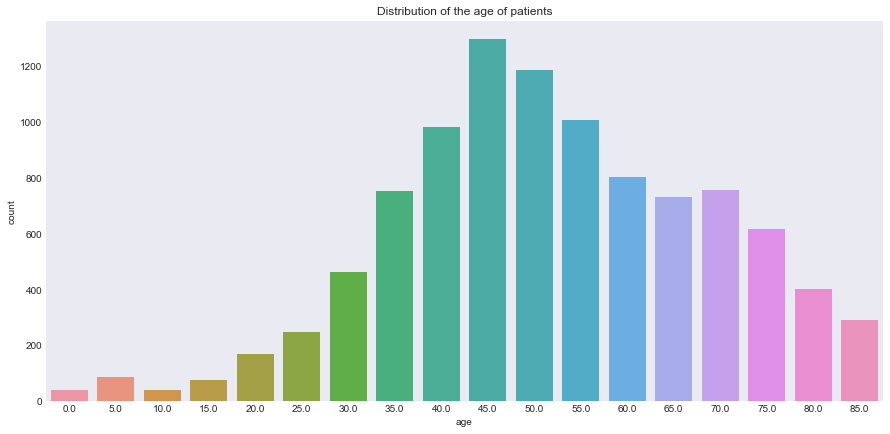

In [12]:
hide_code_in_slideshow()
plt.figure(figsize=(15, 7))
sns.countplot(meta_data['age'])
plt.title('Distribution of the age of patients')

## Missing values and Duplicates

The dataset contains a few missing values and duplicates

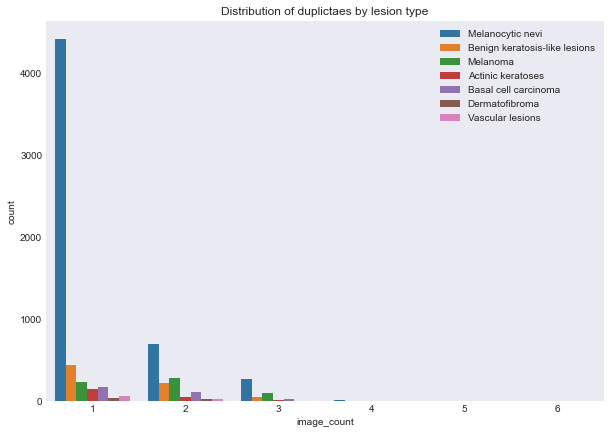

In [13]:
hide_code_in_slideshow()
plt.figure(figsize=(10, 7))
chart = sns.countplot(x="image_count", hue="dx", data=(repetition_counts[['image_count', 'dx', 'lesion_id']]))
plt.legend(loc='upper right')
plt.title("Distribution of duplictaes by lesion type")
hide_code_in_slideshow()

## Target Distribution

There are seven types of skin lesion in the HAM10000 set: 

---
1. Melanocytic nevi - 'nv'
2. Melanoma - 'mel'
3. Benign keratosis-like lesions - 'bkl'
4. Basal cell carcinoma - 'bcc'
5. Actinic keratoses - 'akiec'
6. Vascular lesions - 'vasc'
7. Dermatofibroma - 'df'
---

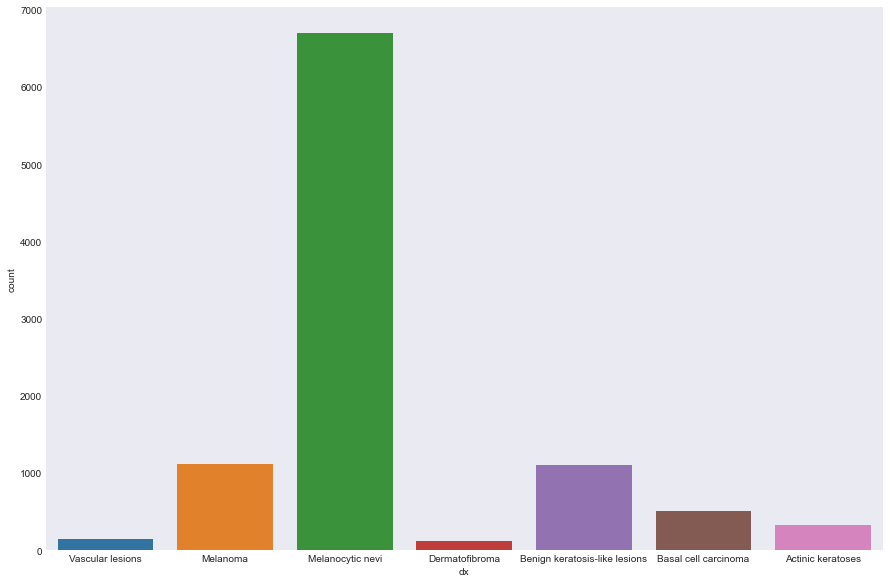

In [14]:
hide_code_in_slideshow()
plt.figure(figsize=(15, 10))
sns.countplot(meta_data['dx'].sort_values(ascending=False))

Representations of each lesion were unbalanced

> 'nv' lesions are overrepresented 

> 'vasc' and 'df' lesions are underrepresented

# DATA PREPARATION 
---

In [15]:
# fill 67 missing age values with mean
meta_data['age'].fillna((meta_data['age'].mean()), inplace = True)
# drop duplicates as duplicates evenly distributed across lesion types 
meta_data = meta_data.drop_duplicates(subset=['lesion_id'], keep = 'first')

### Duplicates and missing data 

- Duplicates were deleted due to low numbers and even target distribution 
- 67 missing values were replaced by column means 

### Balancing and Augmentation

The set was further cleaned by:

> Undersampling 'nv'

> Augmenting the whole dataset to improve training on 'vasc' and 'df'

In [16]:
hide_code_in_slideshow()
meta_data = balance2(meta_data, 1000)
meta_data2 = meta_data.copy() 
frames = [meta_data, meta_data2]
meta_data = pd.concat(frames)

Text(0.5, 1.0, 'New Distribution of lesion types')

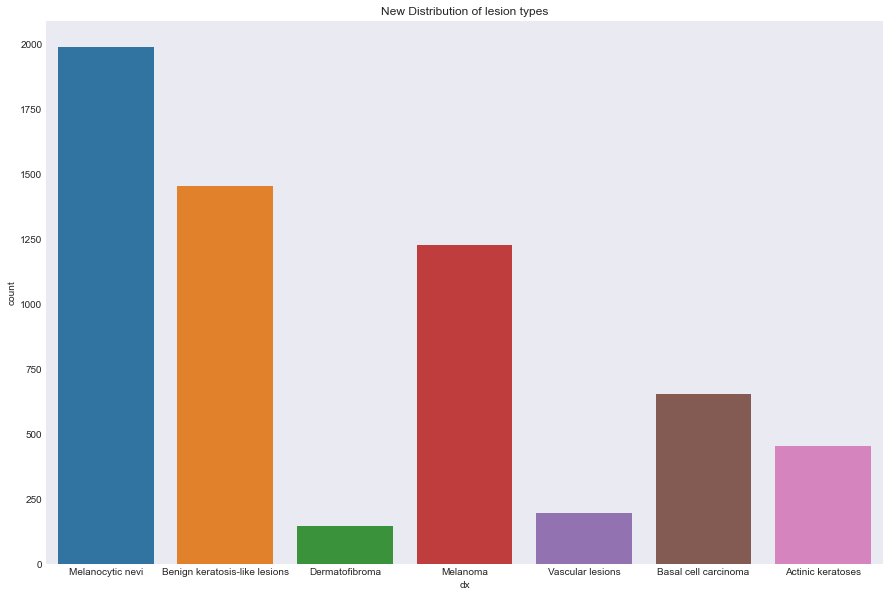

In [17]:
hide_code_in_slideshow()
meta_data = balance(meta_data)
meta_data = augment(meta_data)
plt.figure(figsize=(15, 10))
sns.countplot(meta_data['dx'])
plt.title("New Distribution of lesion types")

## Feature Encoding 
--- 

**Pipeline Structure:**

- OneHotEncoding of categorical features: location, sex, dx_type
- RobustScaler of continuous features: age 
- Custom scaling of image pixels.

# MODEL CONSTRUCTION AND TRAINING
---

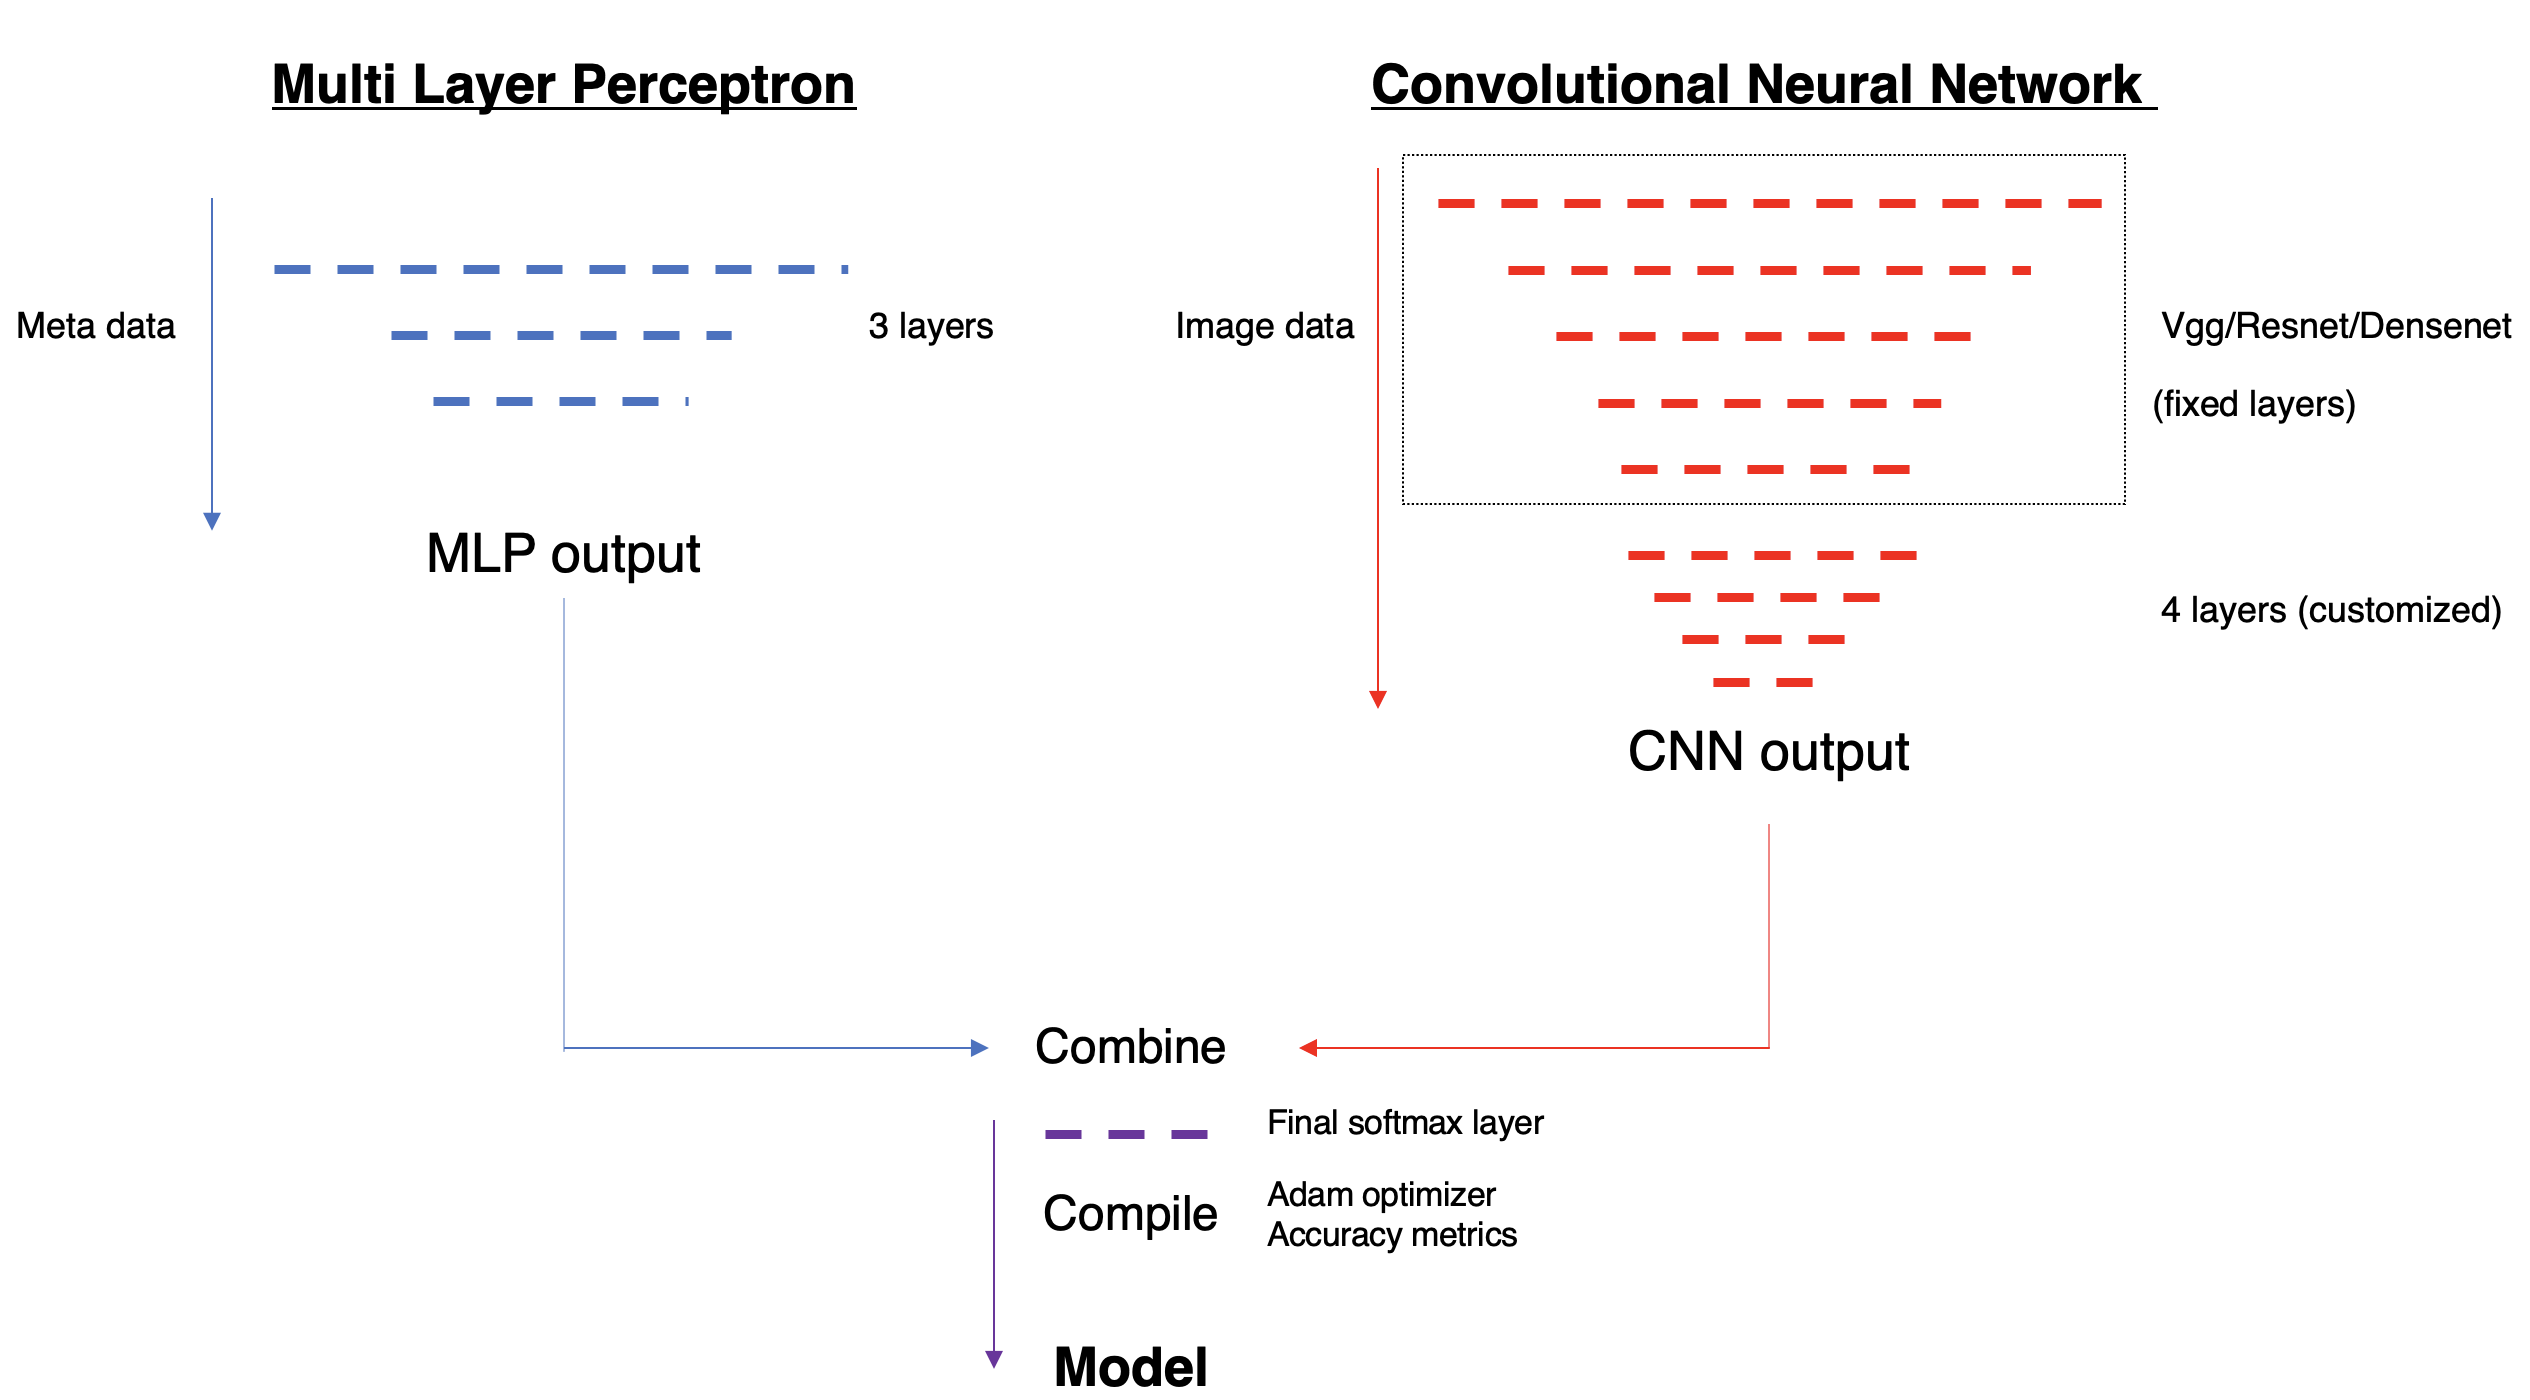

In [18]:
hide_code_in_slideshow()
Image("LWD.png")

In [19]:
def tl_create_mlp(input_dim):
        """
        Create Multi-Layer Perceptron as left_hand fork of mixed neural network for numeric and categorical explanatory variables
        """
        input_shape = (75,100,3)
        selection = 'vgg16'
        model = Sequential()
        model.add(Dense(16, input_dim=input_dim, activation="relu"))
        model.add(Dense(8, activation="relu"))
        model.add(Dense(4, activation="relu"))

        '''
        Use VGG16, Resnet or Densenet as the base model
        Freeze pre-trained layers and add final layers to selected model
        '''
        # Implement VGG16 model
        if selection == 'vgg16':
            model = VGG16(weights='imagenet',
                          input_shape=input_shape,
                          include_top=False)

        # Implement ResNet model
        if selection == 'resnet':
            model = ResNet50(weights='imagenet',
                             input_shape=input_shape,
                             include_top=False,
                             classes=7)

        # Implement DenseNet model
        if selection == 'densenet':
            model = densenet(weights='imagenet',
                                input_shape=input_shape,
                                include_top=False,
                                classes=7)

        # Make pre-trained layers non iterable and add final layers
        for layer in model.layers:
            layer.trainable = False

        inp = Input(shape=input_shape)
        base_output = model(inp)
        x = Flatten()(base_output)
        x = Dense(126, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        x = Dense(4, activation='relu')(x)

        # construct the CNN and return model
        model = Model(inp, x)
        """
        Join forks of network to combine models for all data types
        """
        # create the MLP and CNN models
        mlp = tl_create_mlp(input_dim)
        cnn = tl_create_cnn(input_shape)

        # create the input to our final set of layers as the output of both the MLP and CNN
        combinedInput = concatenate([mlp.output, cnn.output])

        # add final FC layer head with 2 dense layers with final layer as the multi-classifier head
        x = Dense(4, activation="relu")(combinedInput)
        x = Dense(num_labels, activation="softmax")(x)

        # yield final model integrating categorical/numerical data and images into single diagnostic prediction
        model = Model(inputs=[mlp.input, cnn.input], outputs=x)

        # top3 accuracy
        top3_accuracy = functools.partial(top_k_categorical_accuracy, k=3)
        top3_accuracy.__name__ = 'top3_acc'

        # compile the model using BCE as loss
        opt = Adam(lr=1e-4, decay=1e-3 / 200)
        model.compile(loss="categorical_crossentropy",
            optimizer=opt,
            metrics=[categorical_accuracy, top3_accuracy])

        #NB have removed  'precision', 'f1'
        return model

# EVALUATION 
---

### Accuracy

- 78% top three accuracy 

# STREAMLIT 
---

We created an app on streamlit that will 'diagnose' lesions. 

**Do not use our app to (reliably) check your moles**

# LIMITATIONS AND FUTURE PERSPECTIVES
---

**Limitations of the Model Performance**

- Hyperparameter tuning
- Full sized images


# Thank you
---